# Training for Marathon Swimming - An Exploratory Analysis with SQL and Seaborn
By Andrew Cotter

## Introduction
I've successfully trained for and completed multiple marathon (anything over 10km) and "ultramarathon" (definition unclear) swims over the past few years. Needless to say that these all came with their own challenges and required significant training commitments. Training for an event typicallly takes me anywhere from 3-6 months of a strict regimen consisting of pool swimming, open water swimming, and lifting.

<div style="display: flex; gap: 24px; align-items: flex-start; justify-content: center;">
  <figure style="text-align: center; margin: 0;">
    <img src="images/ec_map.jpeg" alt="English Channel map" width="400"/>
    <figcaption>Map of my English Channel crossing in August 2025</figcaption>
  </figure>

  <figure style="text-align: center; margin: 0;">
    <img src="images/rthi.jpeg" alt="RTHI chart" width="400"/>
    <figcaption>Me (yellow cap on the left) doing a long swim in Tomales Bay, CA in August 2024</figcaption>
  </figure>
</div>

At the same time, I am a neurotic user of my Garmin fitness watch - I use it to track all of my activities whether I am actively training for something or not. A while back, I set up a [data pipeline](https://github.com/andrew-cotter/garmin_db) that takes activity summaries from my Garmin account and stores them in a personal database. I've used it previously to set up a [water temperature tracker](https://sfbaytemp.streamlit.app) for the San Francisco Bay.

Now, I am looking for a job ([hire me plz](https://linkedin.com/in/a-cotter)). I've got a lot of free time, and many of the jobs I'm seeing want me to show that I have experience with SQL. That brings me here, to do a deep dive on the data that my Garmin watch has been collecting over the years to give you an idea of what training for marathon swimming looks like (and hopefully help land me a new job).

The only ground-rule that I set for myself with this is that I need to focus on data manipulation in SQL instead of my preferred pandas. Therefore, you will see a lot of SQL in this report, along with some seaborn and matplotlib for data visualization. No pandas, other than turning the query results into dataframes for plotting.

In [ ]:
import pymysql
import toml
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [373]:
def query_db(query, conn, return_df=True):
    """Helper function to run queries"""
    with conn.cursor() as cur:
        cur.execute(query)
    result = cur.fetchall()
    if return_df:
        df = pd.DataFrame(result, columns=[i[0] for i in cur.description])
        return df

In [374]:
# Load secrets
secrets = toml.load(".streamlit/secrets.toml")["connections"]["mysql"]

# Connect to the mysql database
conn = pymysql.connect(
    host=secrets["host"],
    port=secrets["port"],
    database=secrets["dbname"],
    user=secrets["username"],
    password=secrets["password"]
)

***

## A First Look

Lets get to our first set of data. With this query, I will pull all of my activities from 2022 to 2025 and categorize them by the three main activity types - open water swimming, pool swimming, and lifting. 

Data that I want about these activities includes:
 - What year they were recorded
 - The duration of each activity
 - The distance of each swim

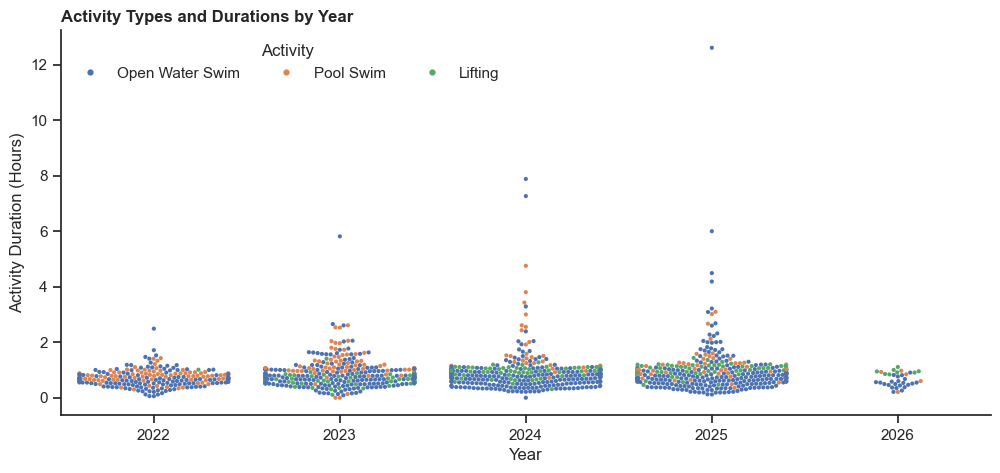

In [ ]:


plt.show()

My first real marathon swim was in August of 2023, and is represented by the ~6 hour blue dot that is clearly separated from the rest of the activities for that year. Similar stories for 2024 and 2025, my main events are pretty clearly separated from all of the training and leisure swimming for that year. In 2024, I had two events of similar duration - 7.5-8 hours, and in 2025 my big swim took 12.5 hours.

Each year has a plethora of activites at or below the 1 hour mark, which adds a bit of visual noise to this plot. I will address that in the next section.



### Focusing on Training

The plot above is stretched quite a bit due to this query containing the long swims I did in each year. Since this analysis is focused on training specifically, I want to omit those.

Additionally, for each year, I will also omit every activity that I did *after* my longest swim of the year. I tend to ramp my activity way down after I've completed my long swim for the year, mostly getting exercise in for manintenance and socializing. Getting rid of these will help remove some of the bloated bottom end of each year.

Finally, I'm going to skip 2022 since I didn't do a marathon swim that year as well as 2026 due to a lack of data so far, I will likely update this later on in the year.

In [377]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(elapsedDuration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE elapsedDuration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(elapsedDuration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year BETWEEN 2023 AND 2025
)
SELECT 
    a.startTimeLocal startTimeLocal,
    DAYOFYEAR(a.startTimeLocal) doy,
    DAYNAME(a.startTimeLocal) dayOfWeek,
    TIME_TO_SEC(TIME(a.startTimeLocal)) / 3600 AS time,
    CAST(a.year AS CHAR(10)) year,
    a.type type,
    a.duration_hr duration_hr,
    SUM(a.duration_hr) OVER(PARTITION BY a.year ORDER BY a.startTimeLocal) cumulative_duration,
    a.distance distance 
FROM allTraining a
JOIN longSwimDate d
    ON a.year=d.year
WHERE a.startTimeLocal<d.longSwimDay;
"""

df=query_db(query, conn)


There's a lot to this query. 
First, there are 3 CTE's used:
 - ```longSwims``` - identify my longest swims in each year by duration.
 - ```longSwimDate``` - use the distances from ```longSwims``` to look up the date and time of those swims.
 - ```allTraining``` - get useful information about all of my activities in years 2023-2025, and categorize them by type.

The final query uses the dates in ```longSwimDate``` to filter my activities to just those that came before the longest swims in 2023-2025. Aside from basic information such as activity type, date, duration, distance, etc... I also grabbed a few pieces of information that I can use in the exploratory analysis, including:
 - day of the year
 - day of the week
 - activity start time (hour of day)
 - cumulative training hours per year

First, let's return to the swamplot for this filtered data to get a general sense of the trends. Additionally, I will break this out by activity to make intra-activity trends more clear.

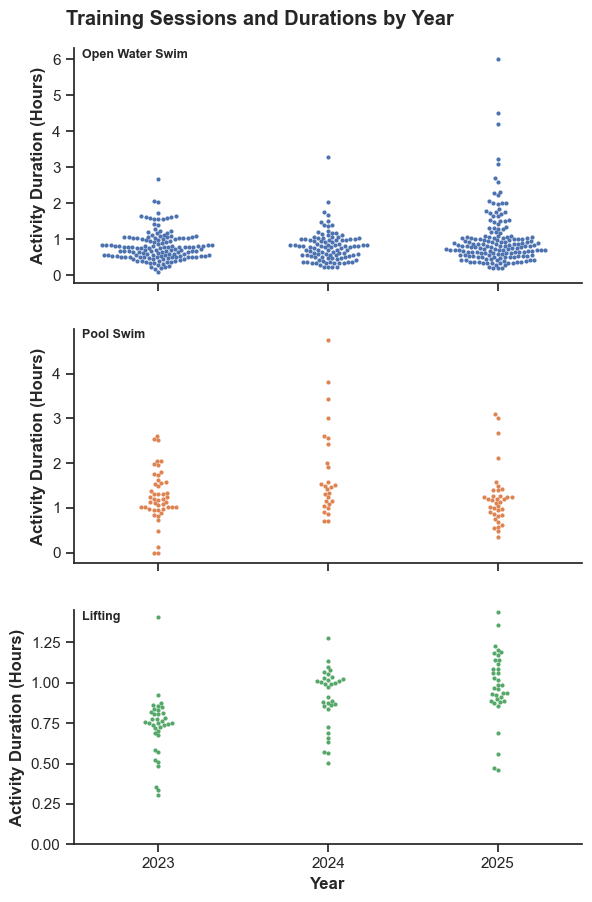

In [378]:
g = sns.FacetGrid(
    df, 
    row = "type", 
    hue="type",
    height=3, 
    aspect=2, 
    sharey=False
)
plot=g.map(
    sns.swarmplot,
    "year",
    "duration_hr",
    size=3  
    )

g=g.set_ylabels("Activity Duration (Hours)", fontweight="bold").set_xlabels("Year", fontweight="bold")


#Subplot titles
g.set_titles("")
for ax, activity in zip(g.axes.flat, g.row_names):
    if activity=="Lifting":
        ax.set_ylim(0,1.45) #Minor tweak to get the lifting plot y axis to start at zero
    ax.text(
        x=-0.45, 
        y=ax.get_ylim()[1],  # near top
        s=activity, 
        ha="left", 
        va="top",
        fontsize=9,
        fontweight="bold"
    )


#Main title    
g.fig.suptitle(
    "Training Sessions and Durations by Year", 
    fontweight="bold",
    x=0.11,
    y=1,
    ha="left"
)

plt.show()

There are a handful of interesting trends to highlight here:
 - 2023 has a high volume of swims, but is lacking in the lenghts of those sessions. My logest swims for that year were all under 3 hours, while 2024 and 2025 have a handful of swims in the 3-6 hour range.
 - 2024 shows some pretty long pool workouts compared to 2023 and 2025 as well as a decrease in open water swims. The reasons for this will be discussed later on.
 - The number of lifting activities remains relatively stable throughout the three years, although they were shorter on average in 2023 compared to other years.

 ***

## Putting in the Hours
This section will focus on hours spent training and look at how many of them I've logged over the years as well as where in the week I was able to fit all of it in.

### Total Training Volume by Year
Here I will look at my cumulative training hours across all activities for each of the three years. No need to write a new query here, since the last one contains all of the information that we need.

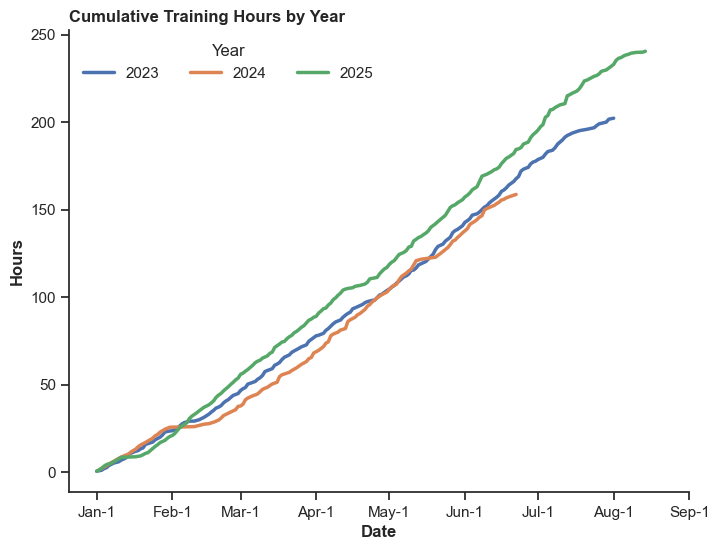

In [379]:
fix, ax = plt.subplots(figsize = (8,6))
plot = sns.lineplot(
    data=df,
    x="doy",
    y="cumulative_duration",
    hue="year",
    linewidth=2.5
)
sns.despine()

ax.set_xticks([1, 32, 60, 91, 121, 152, 182, 213, 244])
ax.set_xticklabels(
    [
        "Jan-1",
        "Feb-1",
        "Mar-1",
        "Apr-1",
        "May-1",
        "Jun-1",
        "Jul-1",
        "Aug-1",
        "Sep-1",
    ]
)
plt.ylabel("Hours", fontweight="bold")
plt.xlabel("Date", fontweight="bold")
plt.title("Cumulative Training Hours by Year", loc="left", fontweight="bold")

plt.legend(title="Year", ncols=3, frameon=False)

plt.show()

A few observations on this plot:
 - The outlier of these 3 lines is 2024. 
   - It ends the earliest because the main event that I had that were was much earlier than in the typical year - late June in 2024 vs early to mid-August in 2023 and 2025.
   - Due to this early date, 2024 also starts out with a slightly higher volume in January than the other years. However, it flattens out in February due to an injury (broken jaw) that prevented me from doing any physical activity for about a month.
   - Another side-effect of this early date was needing to shift all of my swimming volume earlier in the year by a couple of months. The water in the San Francisco Bay is obviously colder during the winter, and the swim that I was preparing for was particularly warm. Therefore, I did most of my long training swims in the pool, explaining a trend that was noted in the swarmplots above.
 - 2025 starts out slow in January before quickly becoming the highest volume year of the three by a pretty wide margin.
 - 2023 is still a high volume year despite the big event I was training for being the shortest. Perhaps I was a bit nervous in preparing for my first marathon swim.

### Fitting training into the week
One might wonder where I find the time to fit all of this training in considering I had a full-time job throughout. The next plot shows when during the week I did my training.

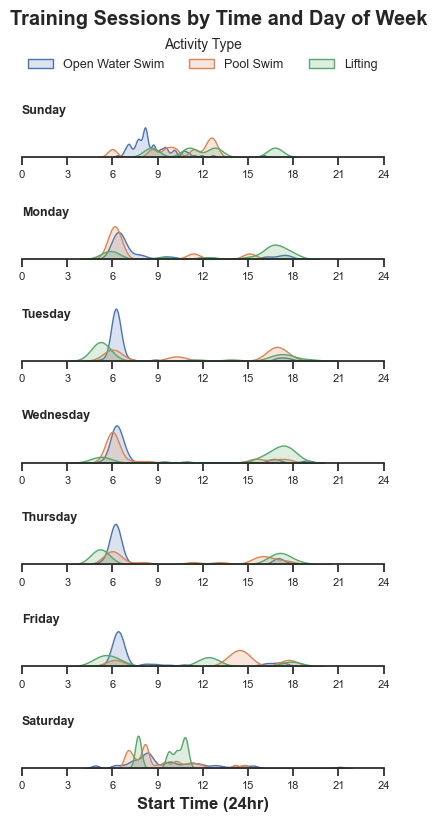

In [380]:
day_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday"
]
g = sns.FacetGrid(
    df,
    row="dayOfWeek",
    hue="type",
    row_order=day_order,
    aspect=4,
    height=1.1,
    sharex=True
)
g.map(
    sns.kdeplot,
    "time",
    fill=True,
    alpha=0.2,
    bw_adjust=0.2
)

#Custom Facet Titles
g.set_titles("")
for ax, day in zip(g.axes.flat, g.row_names):
    ax.text(
        x=0, 
        y=ax.get_ylim()[1]*0.95,  # near top
        s=day, 
        ha="left", 
        va="top",
        fontsize=9,
        fontweight="bold"
    )

#Main plot title
g.fig.suptitle(
    "Training Sessions by Time and Day of Week", 
    fontweight="bold",
    x=0.11,
    y=1.07,
    ha="left"
    )

#Formatting
g.set(
    yticks=[], 
    ylabel=""
    )
g.despine(left=True)

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelsize=8)
    ax.set_xticks([0,3,6,9,12,15,18,21,24])
    ax.set_xticklabels([0,3,6,9,12,15,18,21,24])
plt.xlabel("Start Time (24hr)", fontweight="bold")

#Legend
handles, labels = g.axes[0,0].get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Activity Type",
    loc="upper center",
    bbox_to_anchor=(0.5, 13.5),
    ncol=len(labels),
    frameon=False,
    fontsize=9,
    title_fontsize=10
)

plt.show()

As you can see, I really like training in the early morning. 6am was my most popular time Monday-Friday, especially for open water swimming. I enjoy the morning conditions in the San Francisco Bay (typically less wind) more than the afternoon and evening, not to mention getting to my swimming spot is more of a headache with afternoon traffic.

Lifting is a bit more spread out during the week, I remember years where I would wake up at an ungodly hour to swim **and** lift before going to work, especially in 2023. However, I moved in 2024 to a location where going to the gym was much more convenient, and I therefore shifted to lifting after work.

My activities are much more spread throughout the day on weekends. However, the vast majority of my training was still done in the mornings - just slightly later. It's also noteworthy that Mondays and Fridays appear to be a bit more spread out when compared to Tuesday - Thursday, I'm guessing that is because those days are more likely to be work holidays.

***

## Consistency & Rest Days

As you might have figured out by now, I spent a significant amount of time training. However, the vast majority of my activities were under 1 hour for all three years, so much of my volume came from consistenty doing shorter activities every day and sometimes doing multiple activites in the same day (lifting + swimming, sometimes two swim sessions). Each training year only had a handful of 2+ hour swims sprinkled in.

Rest is also very important, and it is something that I'm looking to do better at in 2026. I've always taken a mindset of 'active rest' days where I will still get out for an easy swim (30 minutes or less at a very leisurely pace) rather than doing nothing all day. With open water swimming specifically, this comes with the added benefit of getting more cold water exposure.

In this section, I will take a look at variables such as training frequency, longest streak of days with recorded activities, and rest days.

### Average Activities Per Week

In [381]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(elapsedDuration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE elapsedDuration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year,
        CAST(elapsedDuration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' then 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' then 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    HAVING type IS NOT NULL 
    AND year BETWEEN 2023 AND 2025
),
weekly AS(
    SELECT
        a.year year,
        a.type type,
        WEEKOFYEAR(a.startTimeLocal) weekOfYear,
        COUNT(a.type) ct
    FROM allTraining a
    JOIN longSwimDate d
        ON a.year=d.year
    WHERE a.startTimeLocal<d.longSwimDay
    GROUP BY a.year, a.type, WEEKOFYEAR(a.startTimeLocal)
)
SELECT
    year,
    AVG(CASE WHEN type = 'Open Water Swim'  THEN ct END) AS "Open Water Swim",
    AVG(CASE WHEN type = 'Pool Swim' THEN ct END) AS "Pool Swim",
    AVG(CASE WHEN type = 'Lifting' THEN ct END) AS "Lifting"
FROM weekly
GROUP BY year
ORDER BY year;
"""

df=query_db(query, conn)

With this query, I am calculating the average number of weekly activities I logged through the years breaking them out by activity type. The ```WEEKOFYEAR``` MySQL function was super useful here for getting the counts, and I am using the ```CASE WHEN``` clauses in the final query to make a "pivoted" table that will be easier for plotting.

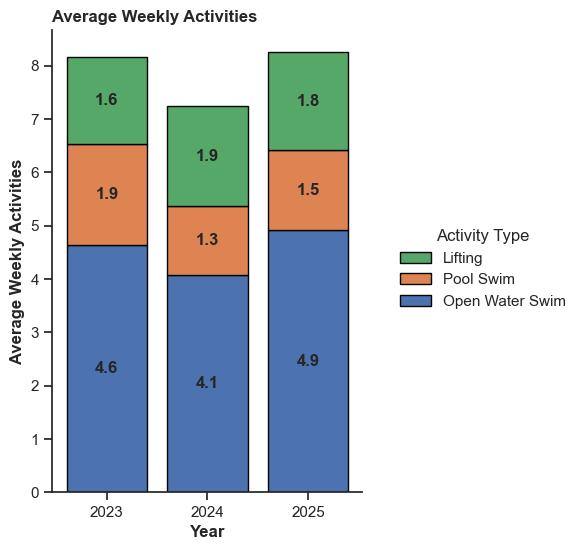

In [382]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.set_theme(
    style="ticks",
)

#Stacked bar chart
bottom=None
for col in df.columns[1:]:
    bars = plt.bar(
        df["year"],
        df[col],
        bottom=bottom,
        label=col,
        edgecolor="black"
    )
    # Add labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}",
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold"
            )
    bottom = df[col] if bottom is None else bottom + df[col]

#Formatting
sns.despine(ax=ax)
plt.ylabel("Average Weekly Activities", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.title("Average Weekly Activities", loc="left", fontweight="bold")\

#Legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[::-1],
    labels[::-1],
    title="Activity Type", 
    frameon=False, 
    loc="upper right",
    bbox_to_anchor=(1.7, 0.6)
    )


plt.show()

On average, I logged just over 8 activities a week during my training in 2023 and 2025. I am a bit surprised at the degree to which the averages drop in 2024, but this is just another signal of the month that I had off in what was a relatively short training period compared to the other years. Despite this, 2024 still had the highest average number of lifting sessions per week, so the drop is mostly due to a decrease in both types of swimming.

2023 and 2025 are both pretty similar, but with a slight increase in open water swimming and a slight decrease in pool swimming focus for 2025. A smart move, as 2025 was in preparation for a channel while 2023 was a lake swim with warmer and smoother conditions.

### Rest Days
Now that we saw how many days I was active, logging any type of activity, lets take a look at how many days I was resting. I will look at resting through two different lenses here:
1. Days with no logged activities
2. Days with exactly 1 activity, a swim under 30 minutes.

In [383]:
query_db("SET @@cte_max_recursion_depth = 2000;", conn=conn, return_df=False)

In [384]:
query = """
WITH RECURSIVE
longestSwims AS (
    SELECT 
        YEAR(startTimeLocal) AS yr,
        MAX(CAST(elapsedDuration AS FLOAT)) AS duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),

longSwimDate AS (
    SELECT 
        startTimeLocal AS longSwimDay, 
        YEAR(startTimeLocal) AS year 
    FROM defaultdb.activities
    WHERE CAST(elapsedDuration AS FLOAT) IN (
        SELECT duration FROM longestSwims
    )
),

allTraining AS (
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) AS year,
        CAST(elapsedDuration AS FLOAT)/3600 AS duration_hr,
        CAST(distance AS FLOAT) AS distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' THEN 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' THEN 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    WHERE YEAR(startTimeLocal) BETWEEN 2023 AND 2025
    HAVING type IS NOT NULL
),

dateRange AS (
    SELECT MIN(DATE(startTimeLocal)) AS d
    FROM allTraining

    UNION ALL

    SELECT d + INTERVAL 1 DAY
    FROM dateRange
    WHERE d < (SELECT MAX(DATE(startTimeLocal)) FROM allTraining)
),

dailyActivities AS (
    SELECT
        DATE(startTimeLocal) AS activity_day,
        COUNT(*) AS num_activities,
        SUM(CASE WHEN type != 'Lifting' AND duration_hr < 0.5 THEN 1 ELSE 0 END) AS short_swim_count
    FROM allTraining
    GROUP BY DATE(startTimeLocal)
),

result AS (

-- Count the days with zero activities
    SELECT
        YEAR(dr.d) year,
        SUM(CASE WHEN a.startTimeLocal IS NULL THEN 1 ELSE 0 END)/COUNT(dr.d)*100 restDays,
        'Zero Activity' as type
    FROM dateRange dr
    LEFT JOIN allTraining a
        ON d = DATE(a.startTimeLocal)
    JOIN longSwimDate l
        ON YEAR(dr.d) = l.year
    WHERE dr.d<l.longSwimDay
    GROUP BY YEAR(dr.d)

-- Count the days with zero activities, omitting Feb 2024
    UNION ALL

    SELECT
        CONCAT(YEAR(dr.d), ' (Feb Omitted)') AS year,
        SUM(CASE WHEN a.startTimeLocal IS NULL THEN 1 ELSE 0 END)/COUNT(dr.d)*100 restDays,
        'Zero Activity' as type
    FROM dateRange dr
    LEFT JOIN allTraining a
        ON dr.d = DATE(a.startTimeLocal)
    JOIN longSwimDate l
        ON YEAR(dr.d) = l.year
    WHERE dr.d<l.longSwimDay
    AND YEAR(dr.d) = 2024
    AND MONTH(dr.d) != 2
    GROUP BY year

-- Count short swim days
    UNION ALL

    SELECT
        YEAR(dr.d) year,
        SUM(CASE WHEN d.num_activities=1 AND d.short_swim_count=1 THEN 1 ELSE 0 END)/COUNT(dr.d)*100 AS shortSwimDays,
        'Active Recovery' AS type
    FROM dateRange dr
    LEFT JOIN dailyActivities d
        ON dr.d = d.activity_day
    JOIN longSwimDate l
        ON YEAR(dr.d) = l.year
    WHERE d.activity_day < l.longSwimDay
    GROUP BY YEAR(dr.d)

       UNION ALL


-- Count short swim days, omitting Feb 2024
    SELECT
        CONCAT(YEAR(dr.d), ' (Feb Omitted)') AS year,
        SUM(CASE WHEN d.num_activities=1 AND d.short_swim_count=1 THEN 1 ELSE 0 END)/COUNT(dr.d)*100 AS shortSwimDays,
        'Active Recovery' as type
    FROM dateRange dr
    LEFT JOIN dailyActivities d
        ON dr.d = d.activity_day
    JOIN longSwimDate l
        ON YEAR(dr.d) = l.year
    WHERE d.activity_day < l.longSwimDay
    AND MONTH(activity_day)!= 2
    AND YEAR(activity_day) = 2024
    GROUP BY CONCAT(YEAR(dr.d), ' (Feb Omitted)')
)

SELECT
    year,
    MAX(CASE WHEN type = 'Zero Activity' THEN restDays END) as 'Zero Activity',
    MAX(CASE WHEN type = 'Active Recovery' THEN restdays END) as 'Active Recovery'
FROM result
GROUP BY year
ORDER BY year;
"""

df=query_db(query, conn)

That was a dandy of a SQL query that took me a bit of time to work through and a bit of AI assistance. It got a bit hacky at the end there due to my promise to do **ALL OF MY DATA MANIPULATION IN SQL**, and I'm also not too well versed in recursives. I'm sure there are ways to optimize this, maybe I will come back and clean it up.
 
 Anyway, this query is trying to see the days that I didn't log an activity within each of my training windows, which is simply represented in the database by a lack of an entry for a specific day. Therefore, this was a case of identifying gaps in time in the database. 

I am doing that by creating a list of all days within the training window (the ```dateRange``` CTE), joining that to the list of activities to create NULL values for ```startTimeLocal```, and then counting those. Due to what I've discussed about 2024 being an earlier swim, I went ahead and normalized all of the counts to percentages.  Additionally, I wanted to see how my rest days in 2024 compared with February included and excluded, so I used ```UNION``` to add another row with the 'corrected' value.

There is another ```UNION``` that I used to add in the short swim days (<30 minutes), before finally using similar ```CASE WHEN``` logic to pivot the table for a stacked bar chart, similar to above. This required the use of yet another CTE (```dailyActivities```) to mark the days where I did a short swim.

Lets take a look at what we got.

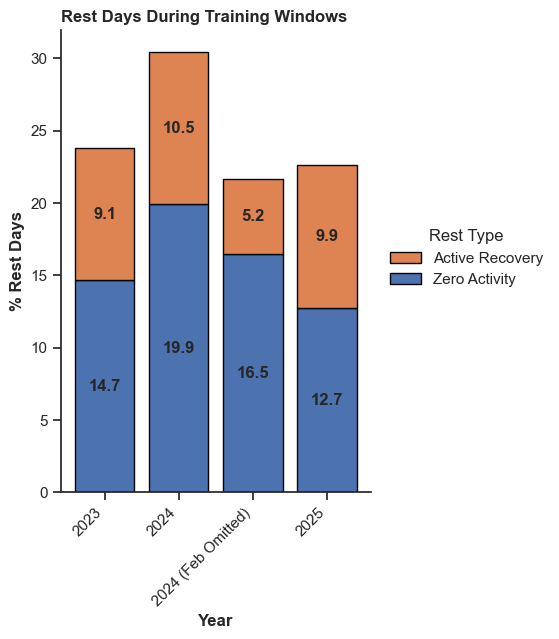

In [385]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.set_theme(
    style="ticks",
)


#Stacked bar chart
bottom=None
for col in df.columns[1:]:
    bars = plt.bar(
        df["year"],
        df[col],
        bottom=bottom,
        label=col,
        edgecolor="black"
    )
    # Add labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + height / 2,
                f"{height:.1f}",
                ha="center",
                va="center",
                fontsize=12,
                fontweight="bold"
            )
    bottom = df[col] if bottom is None else bottom + df[col]

#Formatting
sns.despine(ax=ax)
plt.ylabel("% Rest Days", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.title("Rest Days During Training Windows", loc="left", fontweight="bold")

#Legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[::-1],
    labels[::-1],
    title="Rest Type",
    frameon=False,
    loc="upper right",
    bbox_to_anchor=(1.6, 0.6)
)

plt.show()

Obviously, my rest days considering 2024 in its entirety are inflated due to my very inactive February. Even considering the 'corrected' 2024, I still had the highest percentage of zero activity days. However, I was generally doing less of the 'active recovery' short swims in 2024.

2025 was my lowest proportion of zero activity days at just 12%, which averages less than 1 per week. However, it did see my highest percentage of short active recovery swims.

Overall, it seems like I rested about 18%-20% of the days in my training window across all three years - suprisingly small variability! I'm hoping to up this number a bit in 2026.

### Activity Streaks

Now that we've seen how much rest I got, lets look at the longest streak of activities that I had in each training window. I'll do something similar here that I did with rest days and look at this through two lenses:
1. A raw streak of days where I logged an activity regardless of duration
2. An 'active training' streak of days where I logged either A) a lifting session or B) a swim longer than 30 minutes. 

In [386]:
query = """
WITH longestSwims AS (
    SELECT 
        YEAR(startTimeLocal) AS yr,
        MAX(CAST(elapsedDuration AS FLOAT)) AS duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),

longSwimDate AS (
    SELECT 
        startTimeLocal AS longSwimDay, 
        YEAR(startTimeLocal) AS year 
    FROM defaultdb.activities
    WHERE CAST(elapsedDuration AS FLOAT) IN (
        SELECT duration FROM longestSwims
    )
),

allTraining AS (
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) AS year,
        CAST(elapsedDuration AS FLOAT)/3600 AS duration_hr,
        CAST(distance AS FLOAT) AS distance,
        activityName,
        CASE
            WHEN activityName LIKE '%Open Water%' THEN 'Open Water Swim'
            WHEN activityName LIKE '%Swim%' AND activityName NOT LIKE '%Open Water%' THEN 'Pool Swim'
            WHEN activityName LIKE '%Strength%' OR activityName LIKE '%Weight%' THEN 'Lifting'
            ELSE NULL
        END AS type
    FROM defaultdb.activities
    WHERE YEAR(startTimeLocal) BETWEEN 2023 AND 2025
    HAVING type IS NOT NULL
),

dailyActivities AS (
    SELECT
        DATE(startTimeLocal) AS activityDay,
        COUNT(*) AS num_activities,
        SUM(CASE WHEN type != 'Lifting' AND duration_hr < 0.5 THEN 1 ELSE 0 END) AS short_swim_count
    FROM allTraining
    GROUP BY DATE(startTimeLocal)
),

distinctDatesInWindow AS(
    SELECT DISTINCT DATE(startTimeLocal) AS date
    FROM allTraining
    JOIN longSwimDate l
        ON YEAR(startTimeLocal) = l.year
    WHERE startTimeLocal<l.longSwimDay
),

rawNumbered AS (
    SELECT date AS activityDay,
    ROW_NUMBER() OVER (PARTITION BY YEAR(date) ORDER BY date) AS rn
    FROM distinctDatesInWindow
),

rawStreaks AS (
    SELECT
        activityDay,
        DATE_SUB(activityDay, INTERVAL rn DAY) AS grp
    FROM rawNumbered
),

rawStreakCounts AS(
    SELECT
        YEAR(activityDay) year,
        min(activityDay) streakStart,
        max(activityDay) streakEnd,
        count(*) streak,
        ROW_NUMBER() OVER(PARTITION BY YEAR(activityDay) ORDER BY count(*) DESC) rn
    FROM rawStreaks
    GROUP BY grp, YEAR(activityDay)
    ORDER BY count(*) DESC
),

activeDatesInWindow AS(
    SELECT
        activityDay as date
    FROM dailyActivities
    JOIN longSwimDate l
        ON YEAR(activityDay) = l.year
    WHERE activityDay<l.longSwimDay
    AND (num_activities=1 AND short_swim_count=0)
    OR (num_activities>1)

),

activeNumbered AS (
    SELECT date AS activityDay,
    ROW_NUMBER() OVER (PARTITION BY YEAR(date) ORDER BY date) AS rn
    FROM activeDatesInWindow
),

activeStreaks AS (
    SELECT
        activityDay,
        DATE_SUB(activityDay, INTERVAL rn DAY) AS grp
    FROM activeNumbered
),

activeStreakCounts AS(
    SELECT
        YEAR(activityDay) year,
        min(activityDay) streakStart,
        max(activityDay) streakEnd,
        count(*) streak,
        ROW_NUMBER() OVER(PARTITION BY YEAR(activityDay) ORDER BY count(*) DESC) rn
    FROM activeStreaks
    GROUP BY grp, YEAR(activityDay)
    ORDER BY count(*) DESC
)

SELECT
    year,
    DAYOFYEAR(streakStart) streakStart,
    DAYOFYEAR(streakEnd) streakEnd,
    streak,
    'Raw Streak' as type
FROM rawStreakCounts
WHERE rn IN (1,2,3)


UNION ALL

SELECT
    year,
    DAYOFYEAR(streakStart) streakStart,
    DAYOFYEAR(streakEnd) streakEnd,
    streak,
    'Active Streak' as type
FROM activeStreakCounts
WHERE rn IN (1,2,3)
ORDER BY year DESC, type, streak DESC;
"""

df=query_db(query, conn)


Another pretty complicated query, but at least I'm getting good practice with CTE's and unions! 
Aside from the normal filtering I've used repeatedly to isolate the period before my big swim, I start this query with the ```distinctDatesInWindow``` and ```rawNumbered``` CTEs to get a list of all of the training dates and assign row numbers within each year.

Then, with the ```rawStreaks``` table, I'm subtracting the row numbers from the activity date. The logic here is that, for all dates that are within a given streak of consecutive days, subtracting the row number from the activity date will yield the same date as a result.

For example:

| Activity Date | Row Number | Group      |
|---------------|------------|------------|
| 1/2/2025      | 1          | 1/1/2025   |
| 1/3/2025      | 2          | 1/1/2025   |
| 1/4/2025      | 3          | 1/1/2025   |
| 1/8/2025      | 4          | 1/4/2025   |
| 1/9/2025      | 5          | 1/4/2025   |

The ```DATESUB``` function is used for the date subtration, and the group column can then be used to count the number of rows within each group to get the length of the streak in the ```rawStreakCounts``` table. Finally, I use ```ROW_NUMBER``` again to tag my top streaks in each year and select them in the final query.

I follow a very similar workflow for the active streaks, however instead of getting a list of all the activity dates in my window, I use the ```dailyActivities``` table from the previous query to filter for days where I either did a swim longer than 30 minutes or multiple activities.

Looking at the results:


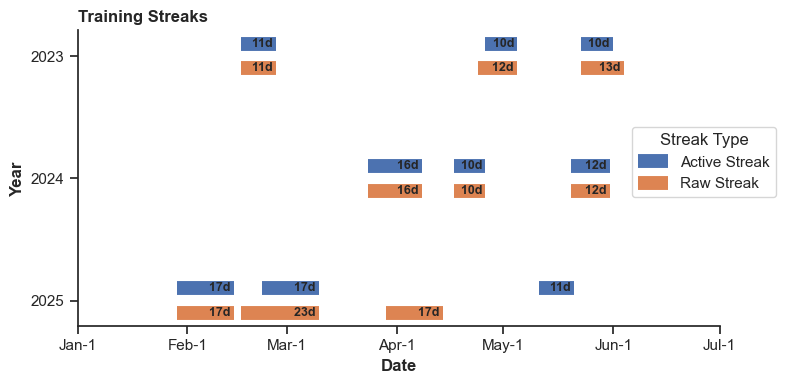

In [387]:
sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(8, 4))

#Setup Formating
year_positions = {year: i for i, year in enumerate(sorted(df["year"].unique()))}

type_offset = {
    "Active Streak": -0.1,
    "Raw Streak": 0.1
}

palette = {
    "Active Streak": "#4C72B0",
    "Raw Streak": "#DD8452"
}


#Plotting
for _, row in df.iterrows():
    y = year_positions[row["year"]] + type_offset[row["type"]]
    ax.hlines(
        y=y,
        xmin=row["streakStart"],
        xmax=row["streakEnd"],
        color=palette[row["type"]],
        linewidth=10,
        label=row["type"]
    )
    #Annotations
    ax.text(
        row["streakEnd"],
        y,
        f"{row['streak']}d ",
        va="center",
        ha="right",
        fontsize=9,
        fontweight="bold"
    )

# Axis and title formatting
ax.set_xticks([1, 32, 60, 91, 121, 152, 182])
ax.set_xticklabels(
    [
        "Jan-1",
        "Feb-1",
        "Mar-1",
        "Apr-1",
        "May-1",
        "Jun-1",
        "Jul-1",

    ]
)


ax.set_yticks(list(year_positions.values()))
ax.set_yticklabels(list(year_positions.keys()))
plt.gca().invert_yaxis()

ax.set_xlabel("Date", fontweight="bold")
ax.set_ylabel("Year", fontweight="bold")
plt.title("Training Streaks", loc="left", fontweight="bold")

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
labels = list(by_label.keys())
handles = list(by_label.values())
ax.legend(
    handles, 
    labels, 
    title="Streak Type",
    loc="upper right",
    frameon=True,
    bbox_to_anchor=(1.1, 0.7)
)

sns.despine()
plt.tight_layout()
plt.show()


As a quick sanity check, it's encouraging to see that all of my active streaks are shorter than or equal to my raw streaks. 

It is interesting to see 2024 where the same date ranges satisfied both categories for all of my 3 longest streaks. This feature is backed up by the fact that my active recovery day percentage in 2024 was just 5.2%, about half of what it was for other years. In other words, I didn't have many short recovery swims to extend my active streaks into longer raw streaks.

We do see this 'streak extension' in other years though, such as in late spring of 2023. I have two active streaks of 10 days spanning April-May, but including short swims extended each of these by 2 and 3 days, respectively.

My streaks got progressively longer over the years for both categories. Noteworthy in 2025 is that that my longest raw streak (23 days) came immediately after my longest active streak (17 days) (coincidentally, that was also my second longest raw streak) in early 2025. In fact, it was just 2 days of separation between the end of the 17 day active streak and the start of the 23 day raw streak. A very different story in 2023, where my logest active streak (11 days) came in late February while the longest raw streak (13 days) started in mid May.

As I've mentioned before, I'm hoping to prioritize rest a bit more in 2026. So, I hope that we will see the streak numbers (especially the active streak) come down a bit compared to 2025.

***

## Water Temperature
Earlier in the discussion, I made mention of cold water. This is an unescapable reality of marathon swimming and, for most swims, something that people specifically need to train for. Cold tolerance can take years for some people to build up, myself included.

So, no analysis of marathon swim preparation is complete without taking a look at how temperature played a role in training. I'll start with a similar SQL query to pull all of my training swims, however I will grab temperature data alongside it instead of features like day of year and time of day.

Unfortunately, Garmin only saves temperature data in increments of degrees Celsius, and the range I train in only varies about 6 or 7°C throughout the year, so this analysis won't be as high precision as I'd like.

In [388]:
query = """
WITH longestSwims AS(
    SELECT 
        YEAR(startTimeLocal) as yr,
        max(CAST(duration as FLOAT)) as duration
    FROM defaultdb.activities
    WHERE activityName LIKE '%Open Water%'
    GROUP BY YEAR(startTimeLocal)
),
longSwimDate AS(
    SELECT 
        startTimeLocal longSwimDay, 
        YEAR(startTimeLocal) as year 
    FROM defaultdb.activities
    WHERE duration IN (
        SELECT duration FROM longestSwims
    )
),
allTraining AS(
    SELECT 
        startTimeLocal, 
        YEAR(startTimeLocal) as year, 
        CAST(duration as FLOAT)/3600 duration_hr,
        CAST(distance as FLOAT) distance,
        activityName,
        ROUND(CAST(minTemperature AS FLOAT)*1.8+32,1) temp
    FROM defaultdb.activities
    HAVING temp IS NOT NULL
    AND duration_hr >0.5
    AND year BETWEEN 2023 AND 2025
    AND temp BETWEEN 50 and 65
),
tempTraining AS(
    SELECT 
        CAST(a.year AS CHAR(10)) year,
        a.temp temp,
        a.duration_hr duration_hr,
        CASE
            WHEN duration_hr>1.5 AND temp=50 THEN 'wetsuit'
            WHEN duration_hr>2.5 AND temp=53.6 THEN 'wetsuit'
            WHEN duration_hr>3 AND temp<55.5 THEN 'wetsuit'
            ELSE NULL
        END AS wetsuit
    FROM allTraining a
    JOIN longSwimDate d
    ON a.year=d.year
    WHERE a.startTimeLocal<d.longSwimDay
    HAVING wetsuit IS NULL
)
SELECT year, temp, max(duration_hr) longestSwim
FROM tempTraining
GROUP BY year, temp;
"""

df=query_db(query, conn)


I'm interested in figuring out whether my cold tolerance got better over the years, so I figured that I would look at what my longest swims times were at each temperature separated by year.

For this query, I made one additional CTE, ```tempTraining``` that has all of the swims and their associated temperatures. However, I had to filter out a few outliers using the ```CASE WHEN``` arguments. As you can tell by the query, these were cold-water swims where I wore a wetsuit. Making this another CTE allows me to filter these out when calculating the max in the final part of the query.

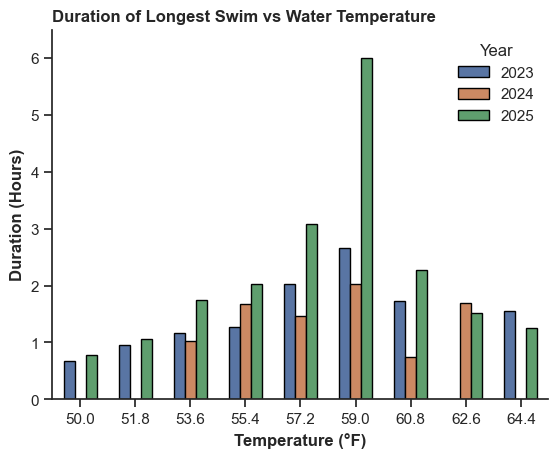

In [389]:
plot=sns.barplot(
    data=df,
    x="temp",
    y="longestSwim",
    hue="year",
    hue_order=["2023", "2024", "2025"],
    width=0.6,
    edgecolor="black"
)
sns.despine()

plt.ylim(0, 6.5)
plt.ylabel("Duration (Hours)", fontweight="bold")
plt.xlabel("Temperature (°F)", fontweight="bold")
plt.title("Duration of Longest Swim vs Water Temperature", loc="left", fontweight="bold")
plt.legend(title="Year", frameon=False)

plt.show()

As evidenced by the increase in swim duration across all temperatues below 60°F, my cold tolerance got much better in 2025. The 6 hour swim shown at 59°F was actually a qualifying swim for my main event that year.

2024 was a bit of a mixed bag. The water didn't get as cold that winter as it typically does, and as mentioned before I wasn't as concerned about cold tolerance for the specific event.

2023 and 2025 show that increasing swim length with increasing temperatures only works out up to a certain point (59°F). I think the reasons for this are two-fold for me:
1) Doing the longest training swims in water colder than my event is a great confidence builder, and I get less worried about pushing the duration after the temperature exceeds 60°F.
2) With August being a big marathon swim month for me, I'm generally ramping down and/or already past my event by the time it really starts to warm up. The water in San Francisco Bay sometimes will stay below 60°F through mid-July, and the warmest temperatures are normally August - October. [Click here to learn more water temperatures in the bay!](https://sfbaytemp.streamlit.app/)

***

## Conclusion
As you can see, marathon swimming requires **a lot** of training! Different swims will present different challenges that may alter how someone prepares for a given route, as evidenced here by my long pool swims in spring 2024 to prepare for an early-season warm swim, or my fuller embrace of cold water swimming in 2025.

Long, multi-hour training swims are important, however they are far from what makes up the bulk of the preparation. What has worked for me has just been consistency - showing up (almost) every day and embracing whatever my plan has in store for me, whether it be 30 minutes in the pool, 3 hours out at sea, or 45 minutes working my legs in the weight room. I know others who have used very different philosophies with great success, and I'm looking forward to seeing how a new focus on getting more rest and shorter activity streaks works for me this year.

  <figure style="text-align: center; margin: 0;">
    <img src="images/deuces.jpg" alt="peace" width="600"/>
    <figcaption>Floating around somwehere in the San Francisco Bay</figcaption>
  </figure>
</div>